In [1]:
import os
import glob
import math
import pandas as pd
import numpy as np

from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import clima_anom as ca
import cartopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%run ../function/function.ipynb

In [2]:
# so = 'manjaro'
so = 'xubuntu'

In [3]:
if so == 'xubuntu':
    base = '/media/'
elif so == 'manjaro':
    base = '/run/media/'
print(f'so  : {so}')
print(f'base: {base}')

so  : xubuntu
base: /media/


In [4]:
shape = list(shpreader.Reader('../mappings/SaoPaulo_Fixed.shp').geometries())

In [5]:
GLM_dir = base + 'arturo/Arturo/Data/GLM/Campinas/2018/grid/old/GLM_2018_03_5min_8kmx8km.nc'
GLM_old = ca.read_netcdf(GLM_dir,2)
lat = GLM_old['lat']
lon = GLM_old['lon']
time_ = GLM_old['time']
GLM_O = GLM_old['flash']

lon2d, lat2d = np.meshgrid(lon,lat)
nt, ny, nx = np.shape(GLM_O)

lat : (45,)
lon : (45,)
time : (8928,)
flash : (8928, 45, 45)


In [6]:
GLM_dir = base + 'arturo/Arturo/Data/GLM/Campinas/2018/grid/GLM_2018_03_5min_8kmx8km.nc'
GLM_new = ca.read_netcdf(GLM_dir,2)
GLM_N = GLM_new['flash']

lat : (45,)
lon : (45,)
time : (8928,)
flash : (8928, 45, 45)


In [7]:
BRD_dir = base + 'arturo/Arturo/Data/BrasilDat/Campinas/2018/grid/BrasilDat_2018_03_5min_8kmx8km.nc'
BRD = ca.read_netcdf(BRD_dir,2)
BRD = BRD['flash']

lat : (45,)
lon : (45,)
time : (8928,)
flash : (8928, 45, 45)


In [21]:
lat_c = -22.8611
lon_c = -47.0563
r = (180)/111

In [22]:
Acum_O = np.zeros([31])
for d in range(31):
    # print(f'Hour: {h}')
    acum = 0
    for t in range(8928):
        if time_[t].day == d+1:
            tmp = np.nansum(GLM_O[t,:,:])
            acum = acum + tmp
        Acum_O[d] = acum

In [23]:
Acum_N = np.zeros([31])
for d in range(31):
    # print(f'Hour: {h}')
    acum = 0
    for t in range(8928):
        if time_[t].day == d+1:
            tmp = np.nansum(GLM_N[t,:,:])
            acum = acum + tmp
        Acum_N[d] = acum

In [24]:
Acum_B = np.zeros([31])
for d in range(31):
    # print(f'Hour: {h}')
    acum = 0
    for t in range(8928):
        if time_[t].day == d+1:
            tmp = np.nansum(BRD[t,:,:])
            acum = acum + tmp
        Acum_B[d] = acum

Text(0.5, 1.0, 'Daily Barplot GLM-BrasilDat 2018-03')

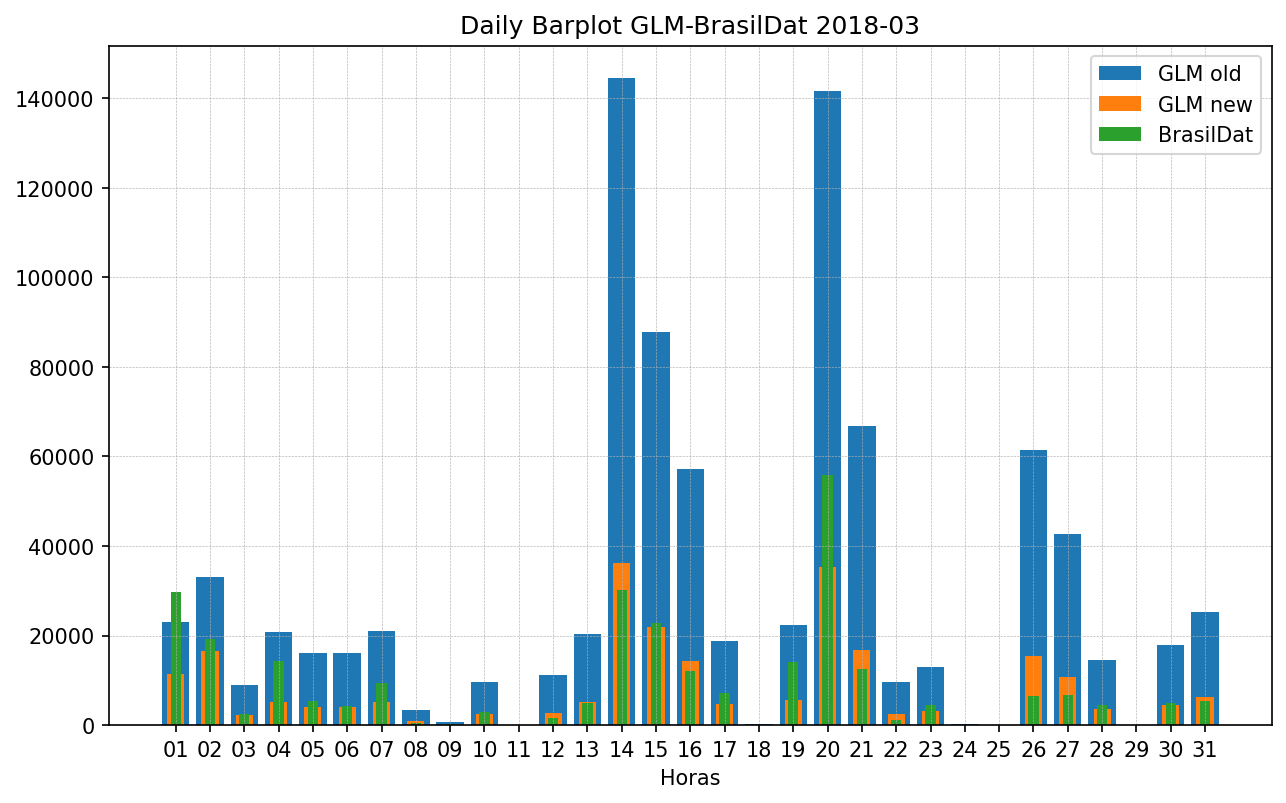

In [25]:
fig = plt.figure(figsize=(10,6),dpi=150)
x = np.arange(0,len(Acum_O))

plt.bar(x,Acum_O,label='GLM old')
plt.bar(x,Acum_N,label='GLM new', width=0.5)
plt.bar(x,Acum_B,label='BrasilDat', width=0.3)

plt.xticks(x, ('01','02','03','04','05','06','07','08','09','10','11','12',
               '13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31'))
plt.xlabel('Horas')
plt.grid(True,linewidth=0.3,linestyle='--')
plt.legend()
plt.title('Daily Barplot GLM-BrasilDat 2018-03')

In [26]:
Regresion = np.zeros([3])

X_train, X_test, y_train, y_test = train_test_split(Acum_N,Acum_B, train_size = 0.9,random_state = 1234,shuffle = True)
corr_test = pearsonr(Acum_N,Acum_B)

modelo = LinearRegression()
modelo.fit(X = X_train.reshape(-1, 1), y = y_train)

Regresion[0] = corr_test[0]
Regresion[1] = modelo.coef_ #m
Regresion[2] = modelo.intercept_ #b

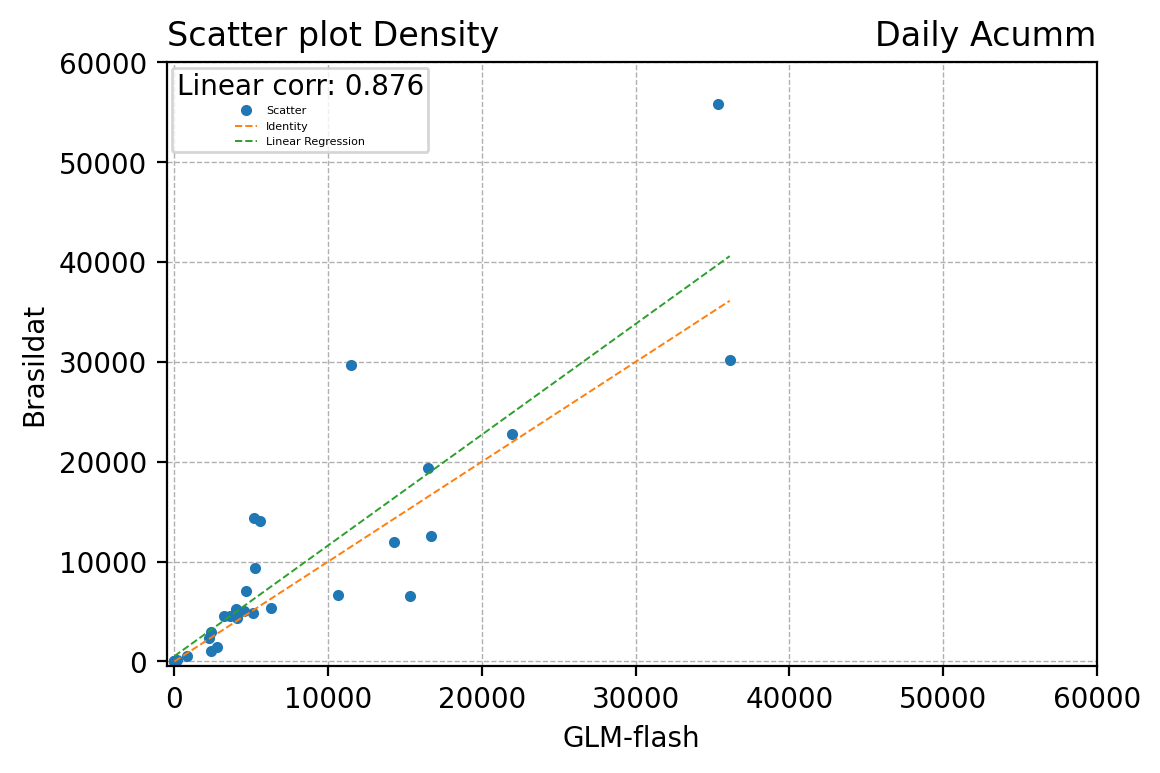

In [28]:
xx = np.arange(0,np.max(Acum_N))
yy = xx
yy_regretion = Regresion[1] * xx + Regresion[2]

fig = plt.figure(figsize=(6,4),dpi=200)
gs = gridspec.GridSpec(1,1)

ax1 = plt.subplot(gs[0, 0])
ax1.plot(Acum_N,Acum_B,'.',label='Scatter')
ax1.plot(xx,yy,'--',linewidth=0.7,label='Identity')
ax1.plot(xx,yy_regretion,'--',linewidth=0.7,label='Linear Regression')

ax1.set_ylim(-500,60000)
ax1.set_xlim(-500,60000)

ax1.set_ylabel('Brasildat')
ax1.set_xlabel('GLM-flash')
ax1.set_title('Scatter plot Density',loc='left')
ax1.set_title('Daily Acumm',loc='right')

leg_title = 'Linear corr: '+ str(np.round(Regresion[0],3))
legend = ax1.legend(title=leg_title,loc=2, fontsize=4)
plt.grid(linewidth=0.5,linestyle='--')

# salida = '../images/Scatter_GLM_BrasilDat_daily.png'
# plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor='white')

In [29]:
Acum_O = np.zeros([24])
for h in range(24):
    acum = 0
    for t in range(8928):
        if time_[t].hour == h:
            tmp = np.nansum(GLM_O[t,:,:])
            acum = acum + tmp
        Acum_O[h] = acum

In [30]:
Acum_N = np.zeros([24])
for h in range(24):
    acum = 0
    for t in range(8928):
        if time_[t].hour == h:
            tmp = np.nansum(GLM_N[t,:,:])
            acum = acum + tmp
        Acum_N[h] = acum

In [31]:
Acum_B = np.zeros([24])
for h in range(24):
    acum = 0
    for t in range(8928):
        if time_[t].hour == h:
            tmp = np.nansum(BRD[t,:,:])
            acum = acum + tmp
        Acum_B[h] = acum

Text(0.5, 1.0, 'Hourly Barplot GLM-BrasilDat 2018-03')

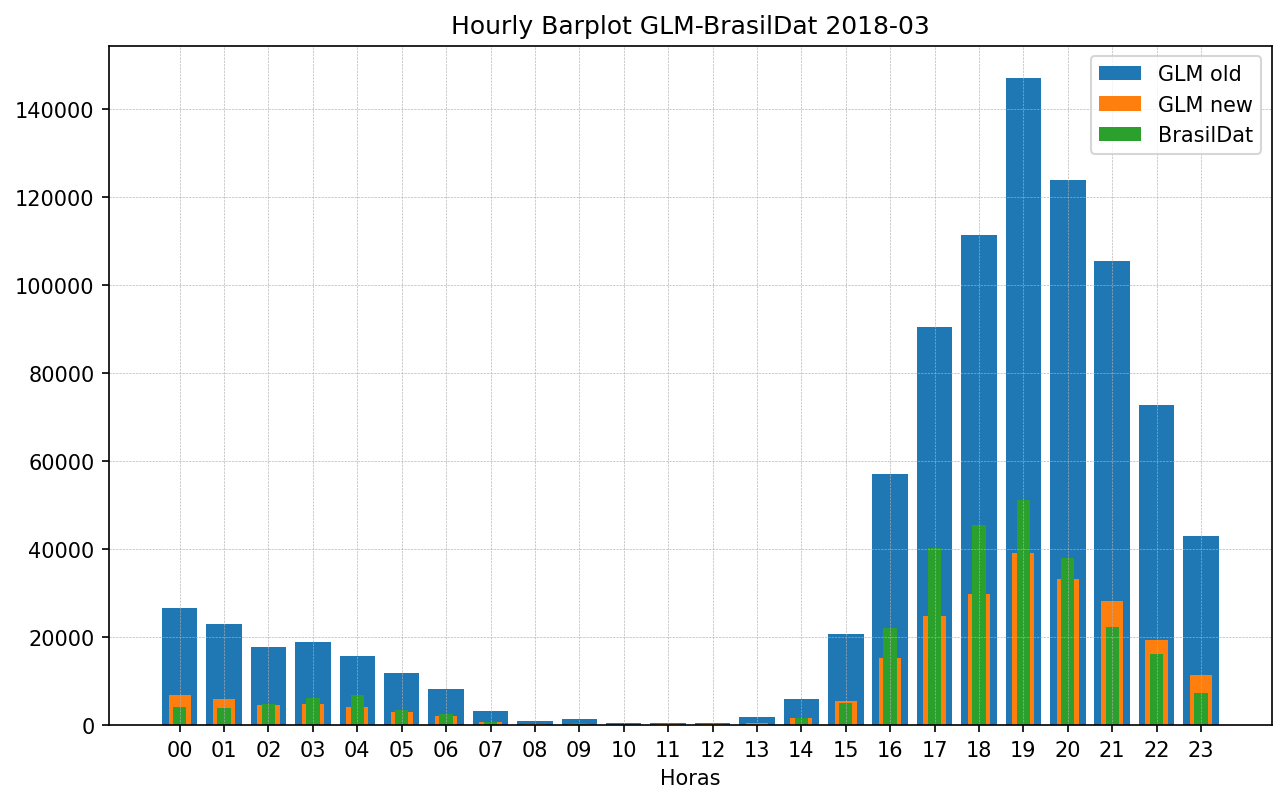

In [32]:
fig = plt.figure(figsize=(10,6),dpi=150)
x = np.arange(0,len(Acum_O))

plt.bar(x,Acum_O,label='GLM old')
plt.bar(x,Acum_N,label='GLM new', width=0.5)
plt.bar(x,Acum_B,label='BrasilDat', width=0.3)

plt.xticks(x, ('00','01','02','03','04','05','06','07','08','09','10','11','12',
               '13','14','15','16','17','18','19','20','21','22','23'))
plt.xlabel('Horas')
plt.grid(True,linewidth=0.3,linestyle='--')
plt.legend()
plt.title('Hourly Barplot GLM-BrasilDat 2018-03')

In [33]:
Regresion = np.zeros([3])

X_train, X_test, y_train, y_test = train_test_split(Acum_N,Acum_B, train_size = 0.9,random_state = 1234,shuffle = True)
corr_test = pearsonr(Acum_N,Acum_B)

modelo = LinearRegression()
modelo.fit(X = X_train.reshape(-1, 1), y = y_train)

Regresion[0] = corr_test[0]
Regresion[1] = modelo.coef_ #m
Regresion[2] = modelo.intercept_ #b

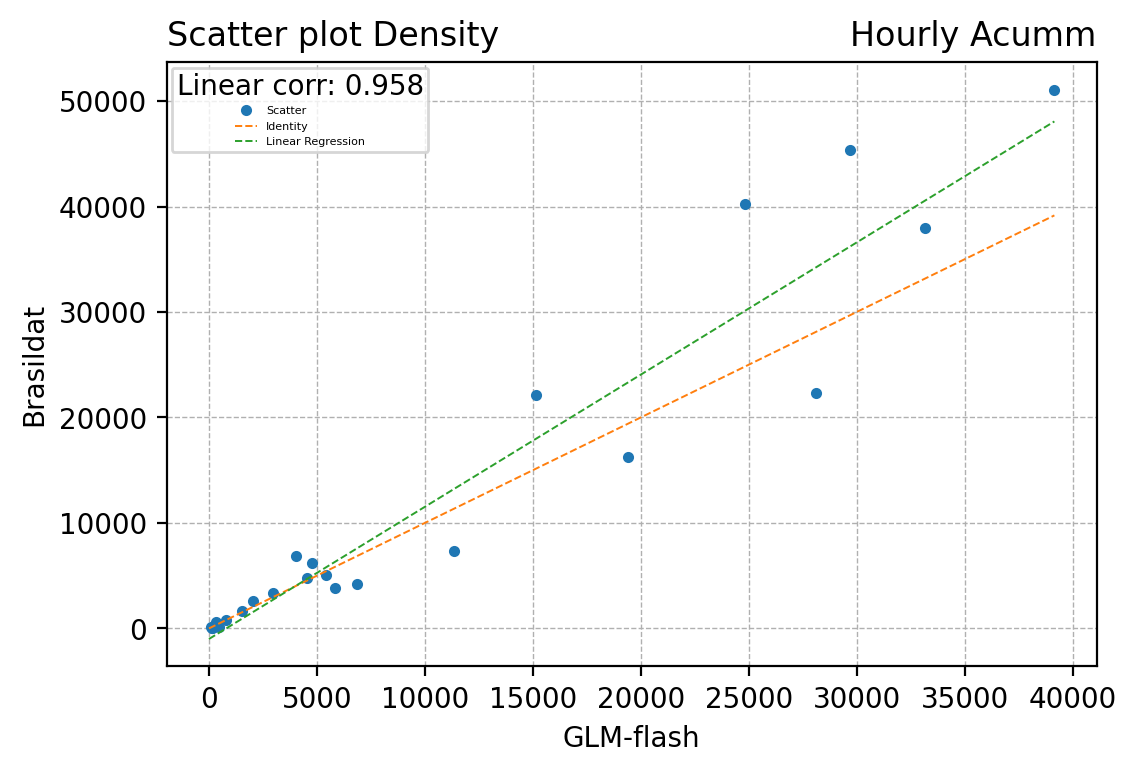

In [34]:
xx = np.arange(0,np.max(Acum_N))
yy = xx
yy_regretion = Regresion[1] * xx + Regresion[2]

fig = plt.figure(figsize=(6,4),dpi=200)
gs = gridspec.GridSpec(1,1)

ax1 = plt.subplot(gs[0, 0])
ax1.plot(Acum_N,Acum_B,'.',label='Scatter')
ax1.plot(xx,yy,'--',linewidth=0.7,label='Identity')
ax1.plot(xx,yy_regretion,'--',linewidth=0.7,label='Linear Regression')

# ax1.set_ylim(-5000,140000)
# ax1.set_xlim(-5000,140000)

ax1.set_ylabel('Brasildat')
ax1.set_xlabel('GLM-flash')
ax1.set_title('Scatter plot Density',loc='left')
ax1.set_title('Hourly Acumm',loc='right')

leg_title = 'Linear corr: '+ str(np.round(Regresion[0],3))
legend = ax1.legend(title=leg_title,loc=2, fontsize=4)
plt.grid(linewidth=0.5,linestyle='--')

# salida = '../images/Scatter_GLM_BrasilDat_daily.png'
# plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor='white')